In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import os
import yaml

In [76]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [77]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [78]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.head()

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints,numMinutes
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,22.0,20.0,0.909,37.0,11.0,48.0,18.0,10.0,30.0,240.0
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,21.0,17.0,0.810,27.0,11.0,38.0,18.0,13.0,-30.0,240.0
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,22.0,13.0,0.591,38.0,8.0,46.0,12.0,9.0,10.0,240.0
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,13.0,9.0,0.692,31.0,8.0,39.0,14.0,11.0,-10.0,240.0
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,19.0,16.0,0.842,33.0,10.0,43.0,21.0,19.0,-30.0,240.0


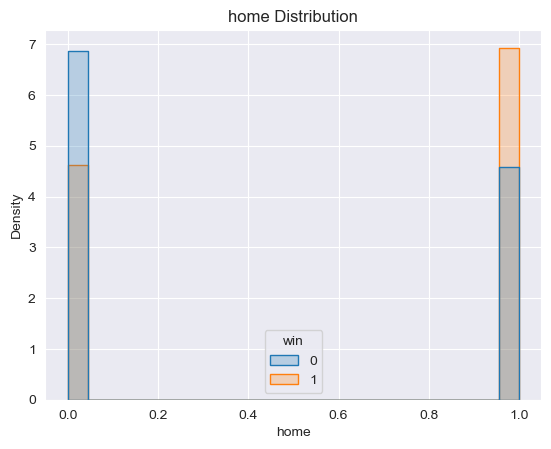

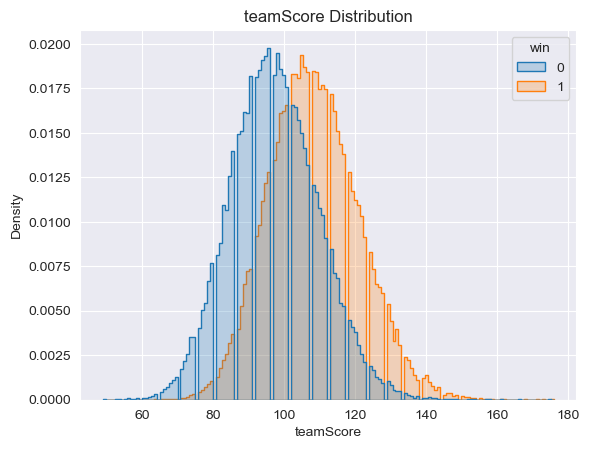

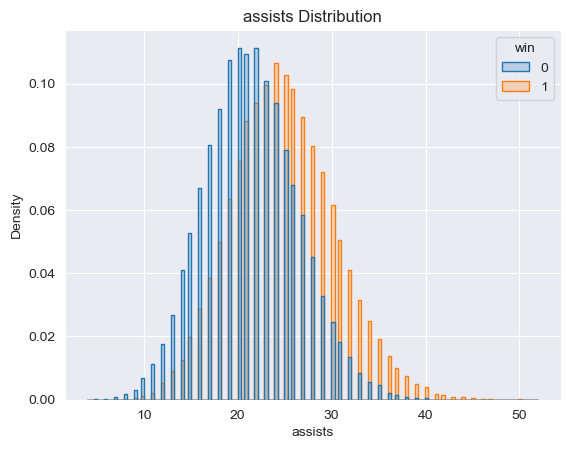

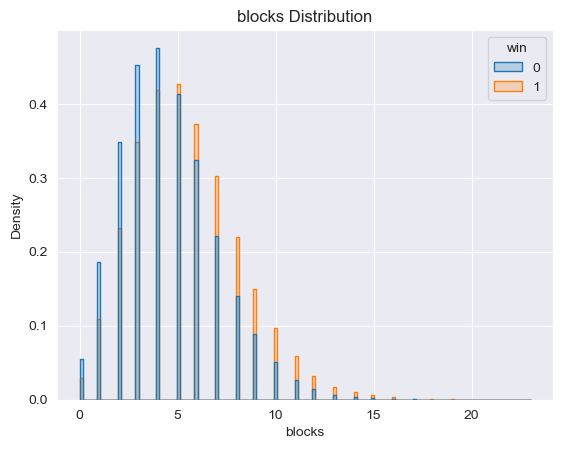

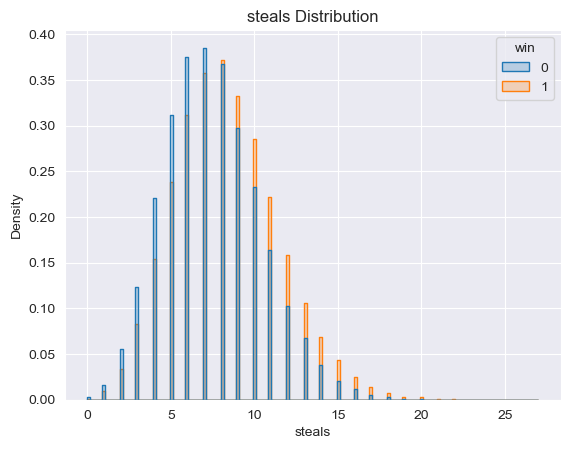

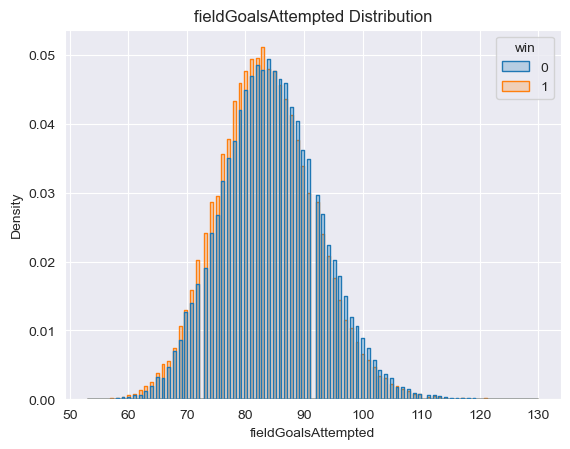

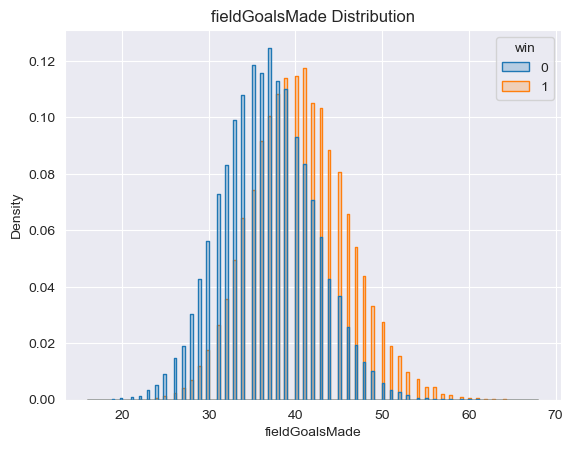

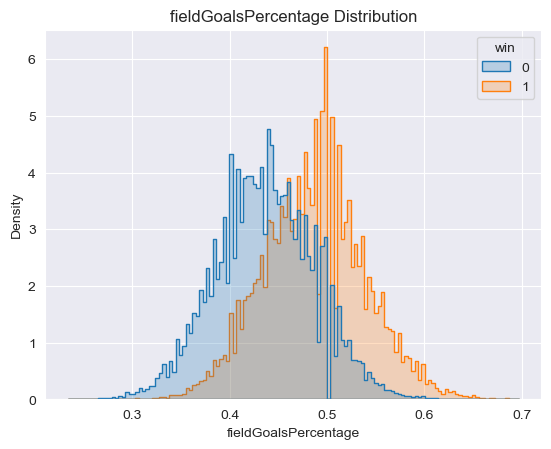

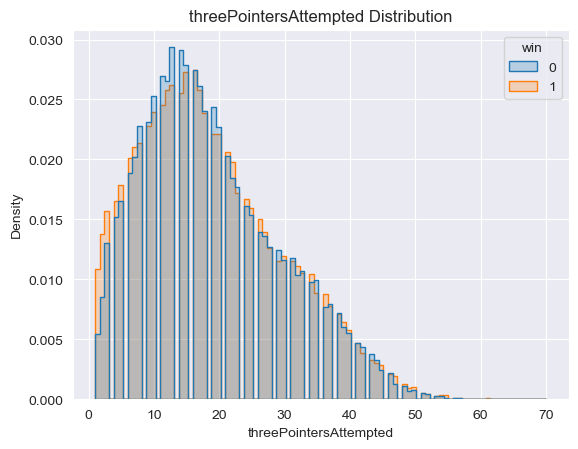

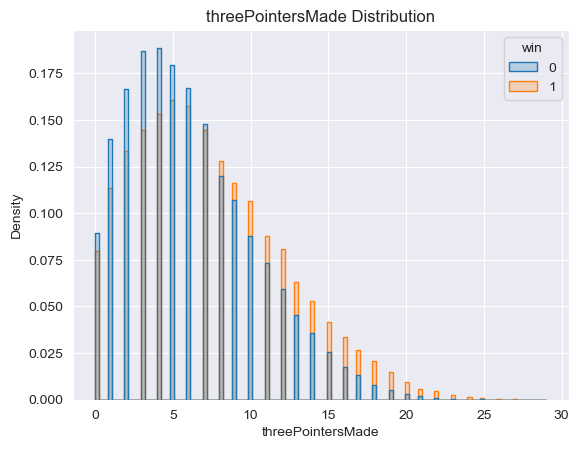

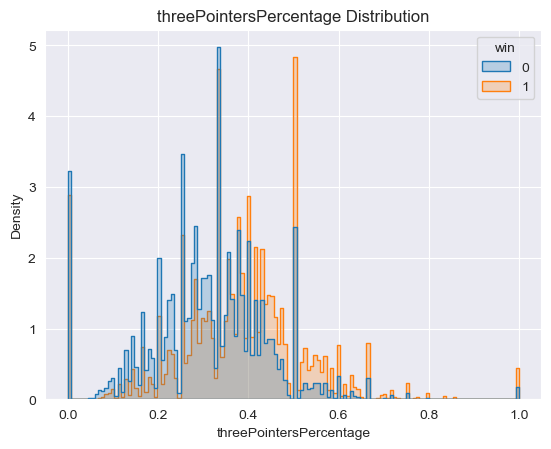

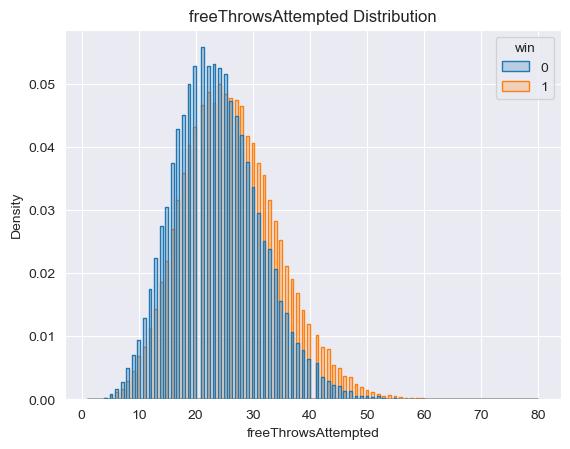

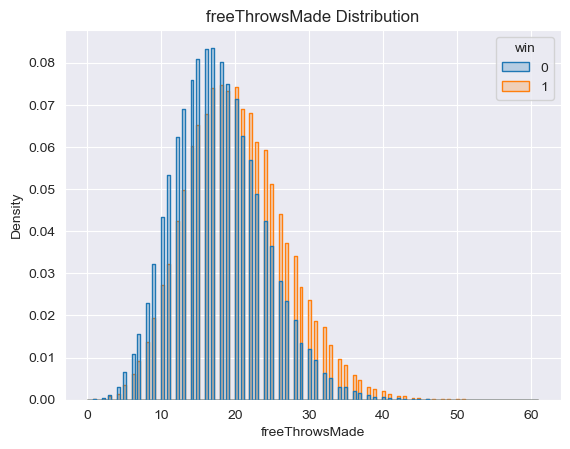

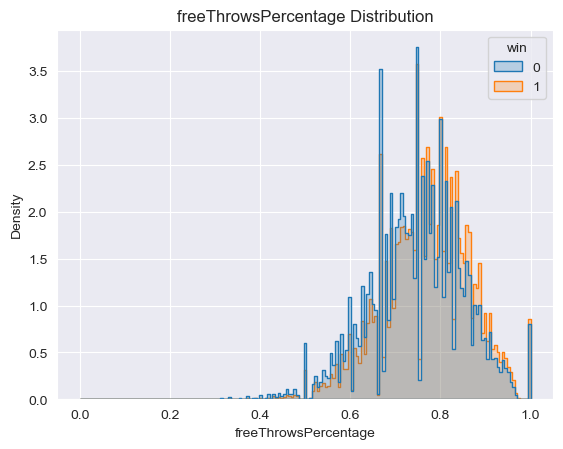

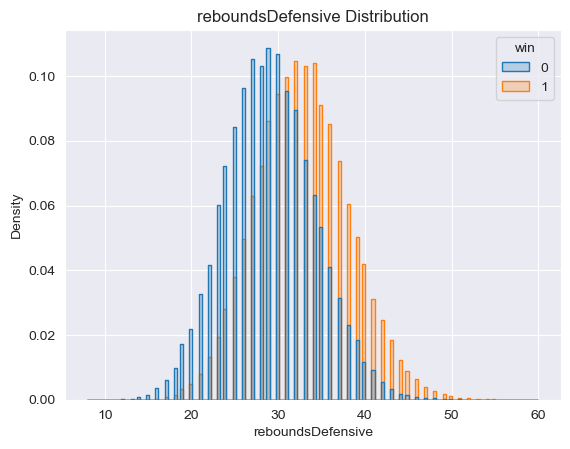

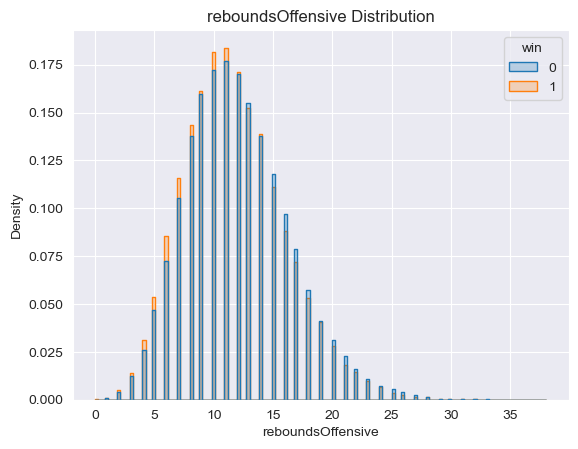

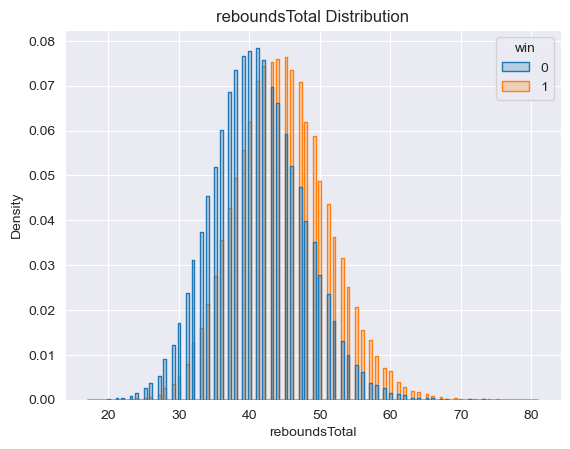

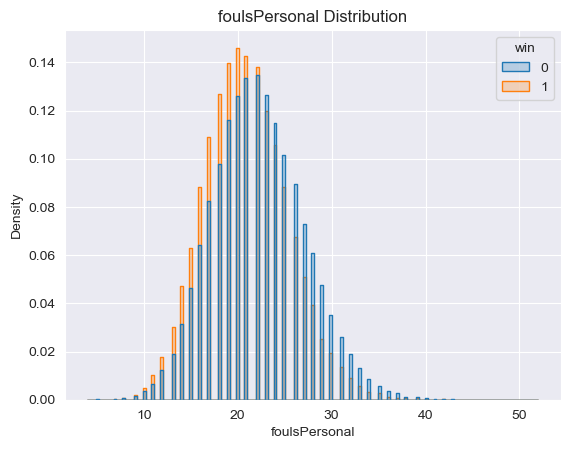

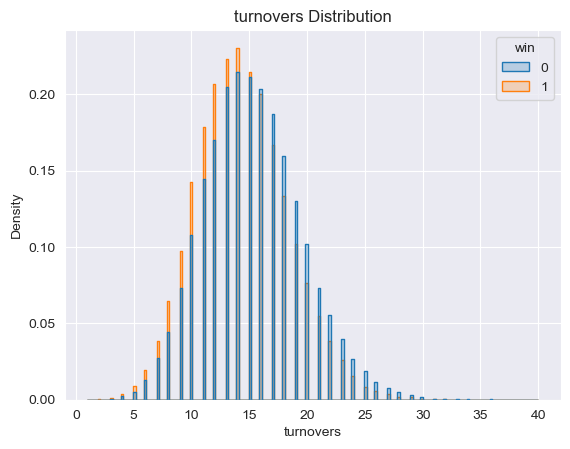

In [79]:
cols = ["home", "teamScore", "assists", "blocks", "steals", "fieldGoalsAttempted", "fieldGoalsMade", "fieldGoalsPercentage", "threePointersAttempted", "threePointersMade", "threePointersPercentage", "freeThrowsAttempted", "freeThrowsMade", "freeThrowsPercentage", "reboundsDefensive", "reboundsOffensive", "reboundsTotal", "foulsPersonal", "turnovers"]

for i, col in enumerate(cols):
    sns.histplot(data=team_statistics_df, x=col, hue='win', element='step', stat='density')
    #sns.histplot(team_statistics_df[col], ax=axs[i])
    plt.title(f"{col} Distribution")
    plt.show()



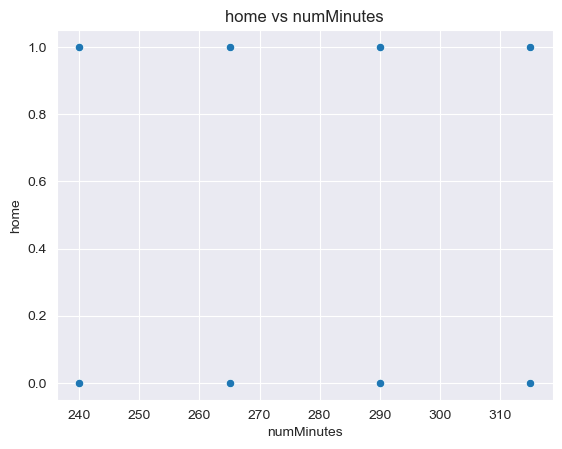

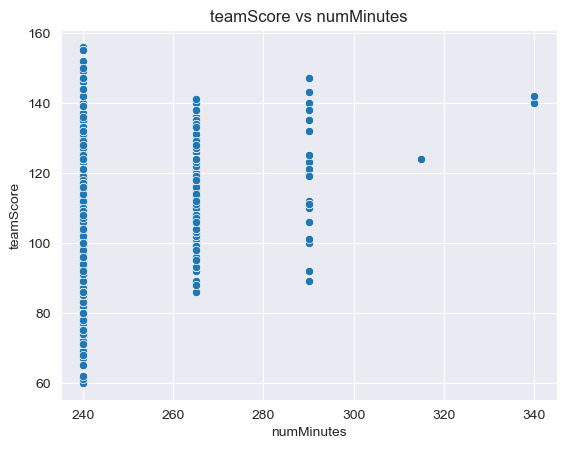

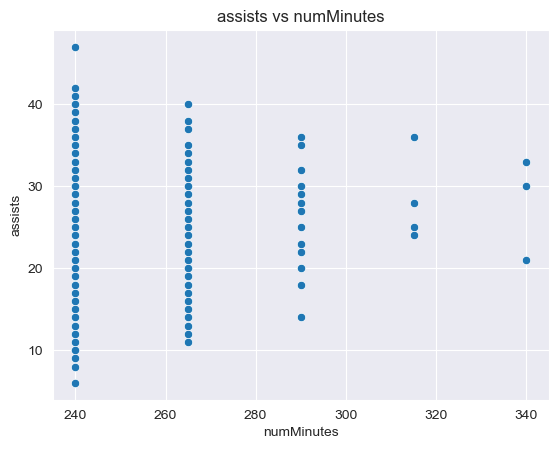

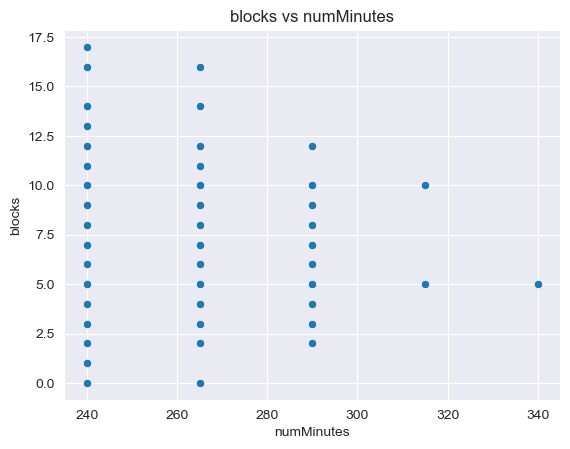

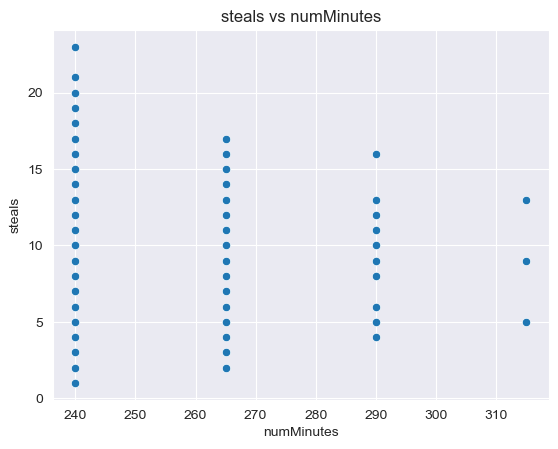

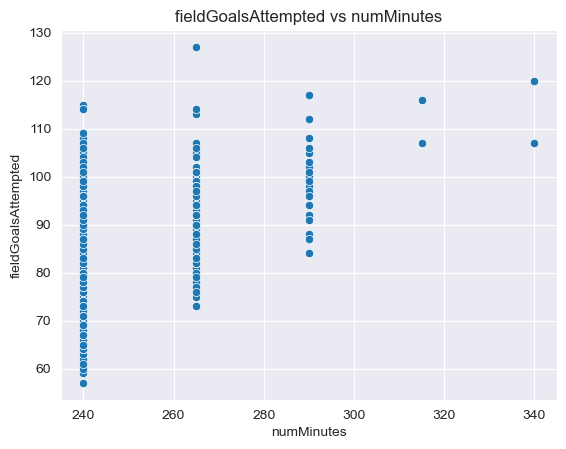

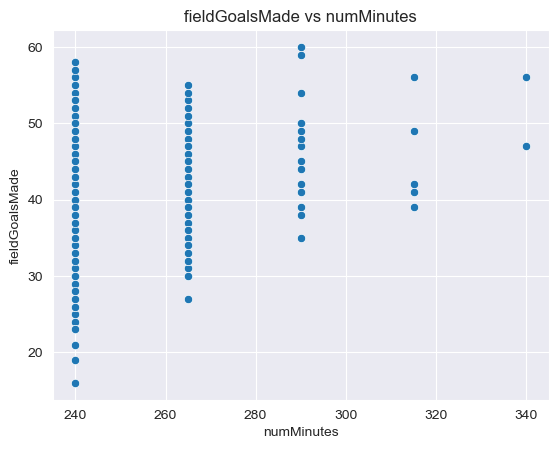

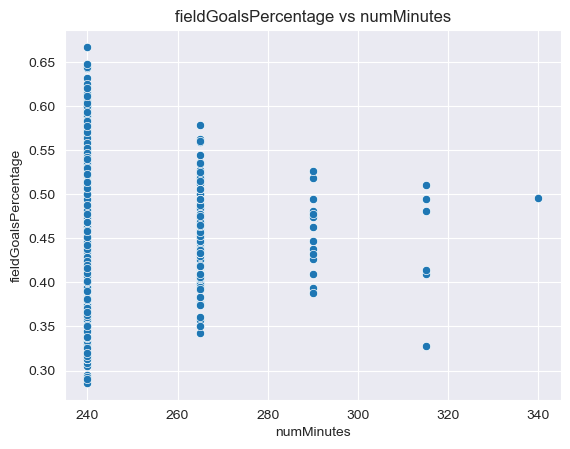

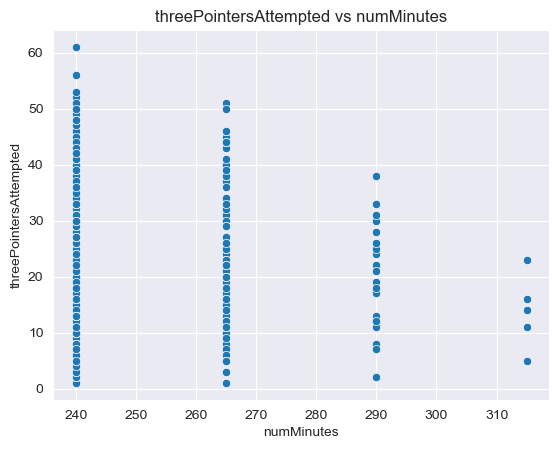

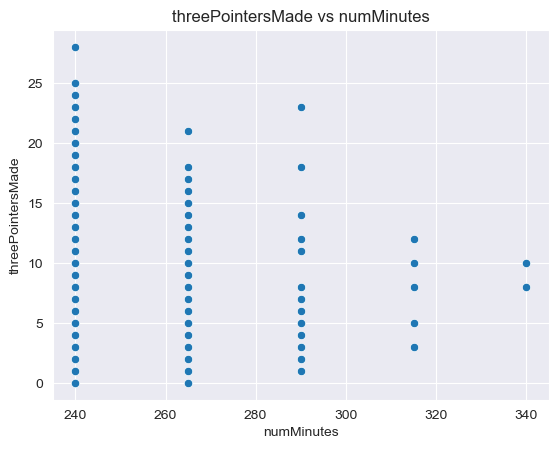

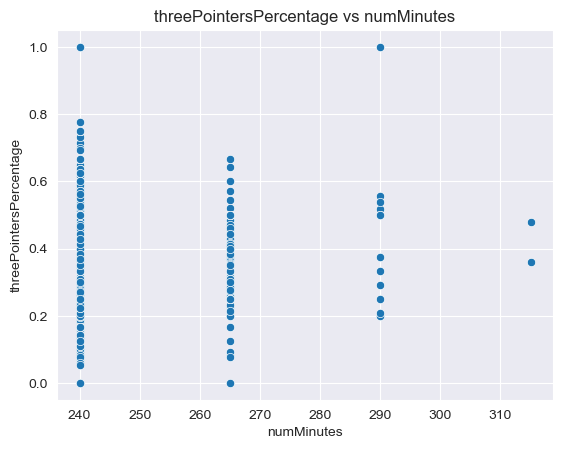

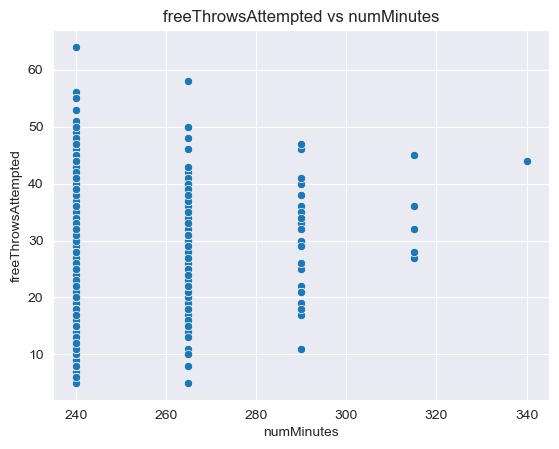

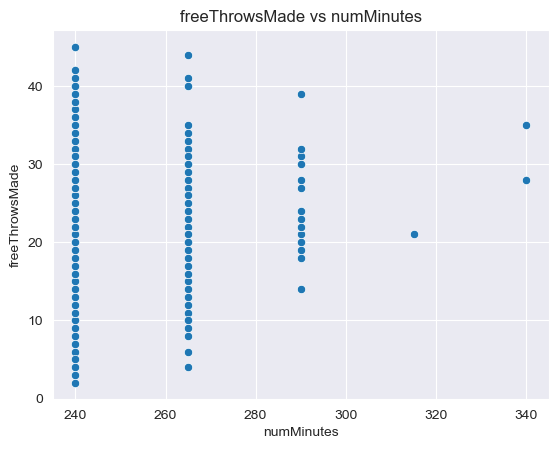

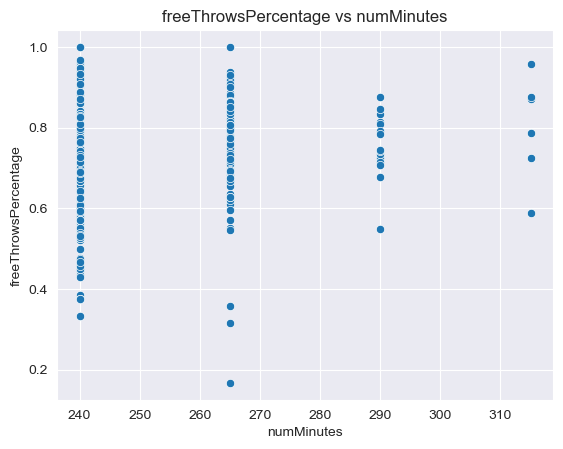

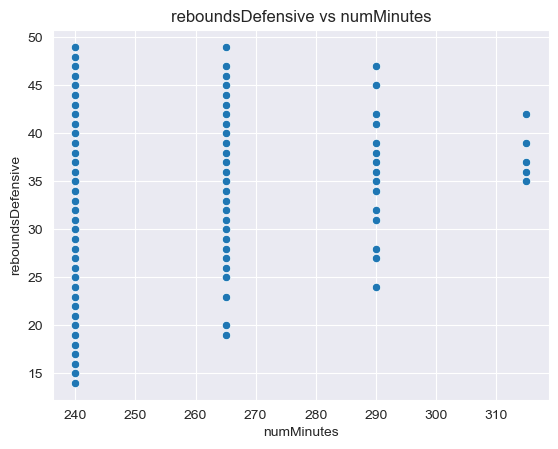

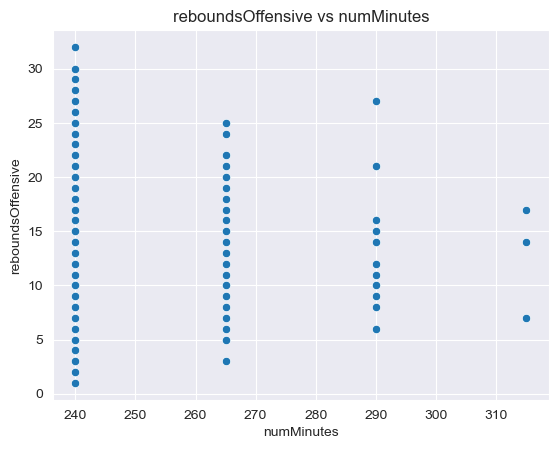

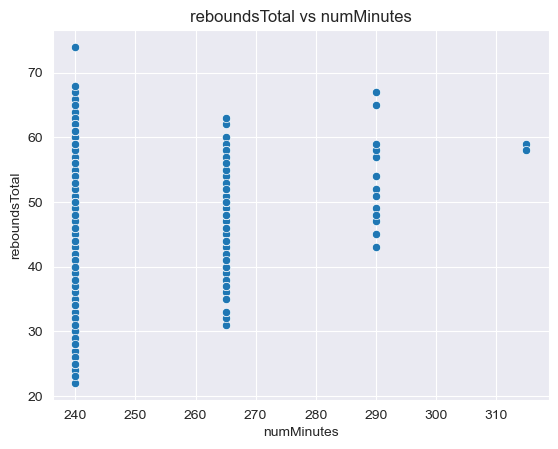

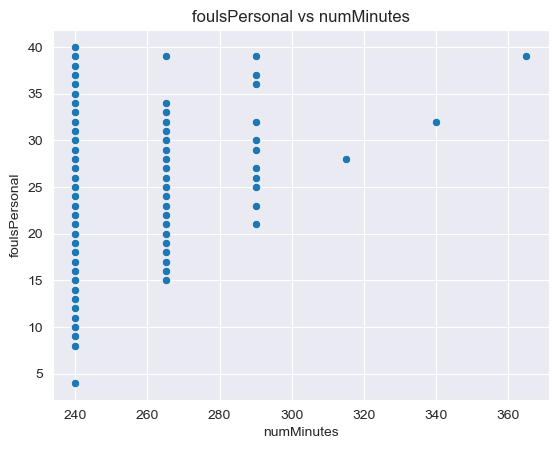

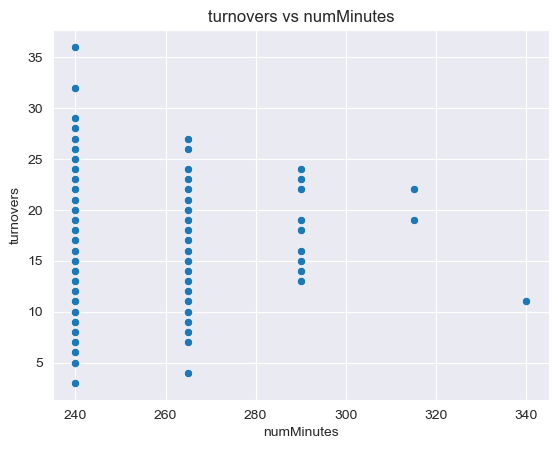

In [80]:
for col in cols:
    sns.scatterplot(x='numMinutes', y=col, data=team_statistics_df.sample(3000))
    plt.title(f'{col} vs numMinutes')
    plt.show()

Since we are dealing with countable variables, such as assists, rebounds, steals etc., if we want to show whether a winning team has more "skill" in this variable than the other, we have to account for the fact that if a team simply has more chances to score, it will have more assists, rebounds, steals etc. even though they are not better at these skills than the other team. This can be seen by the plots above showing that, by playing more minutes in a game (Overtime games for example), the trend seems to go higher for these countable variables, and the same will therefore be true if we can pack more attempts within the same minutes. So, we have to adjust the variables by the amount of possessions a team is playing at.

Conventionally, a possession is defined as a play that ends either in a turnover, a field goal, or a free throw (foul). Additionally, possessions are extended when the team gets an offensive rebound. The formula for possessions is therefore:
$$Possessions = FGA + (0.44 * FTA) + TO - OREB$$
Source: https://support.fastmodelsports.com/support/solutions/articles/9000231009-how-do-we-estimate-pace-and-possessions-

In [81]:
team_statistics_df["possessions"] = team_statistics_df["fieldGoalsAttempted"] + (0.44 * team_statistics_df["freeThrowsAttempted"]) + team_statistics_df["turnovers"] - team_statistics_df["reboundsOffensive"]

With the possessions, we can then normalize the countable variables by the amount of possessions a team is playing at.

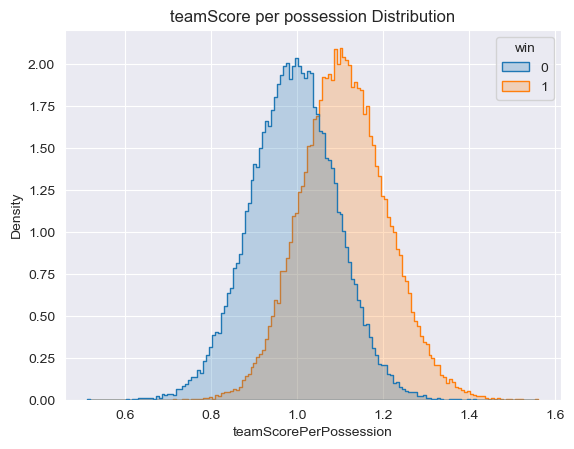

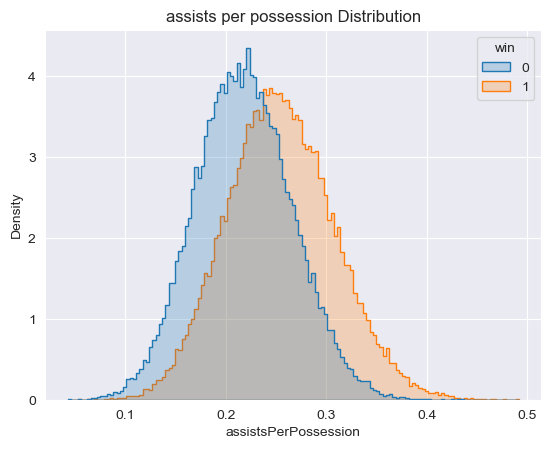

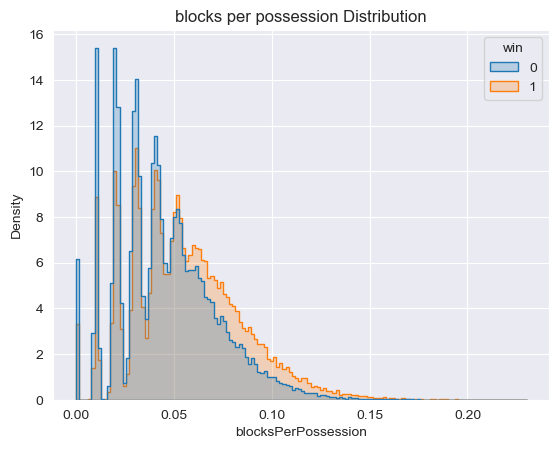

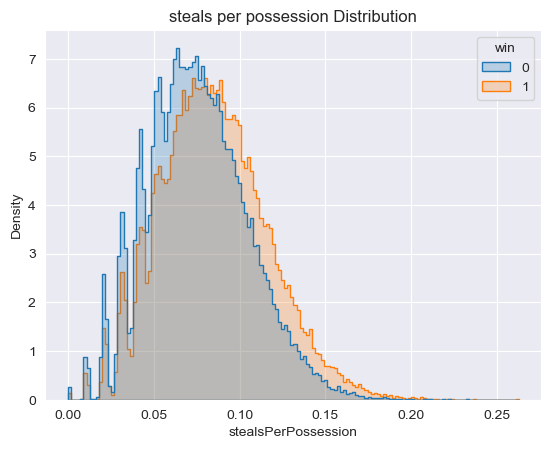

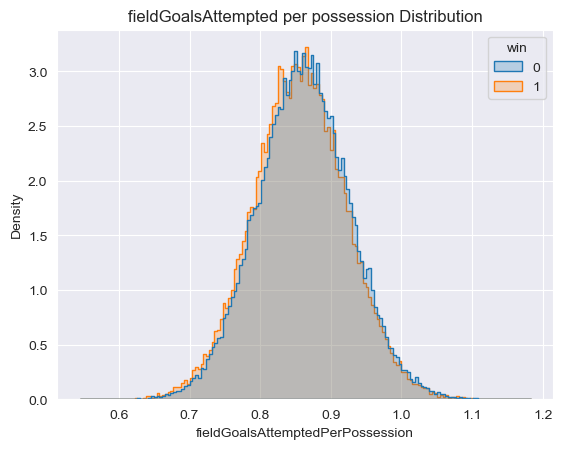

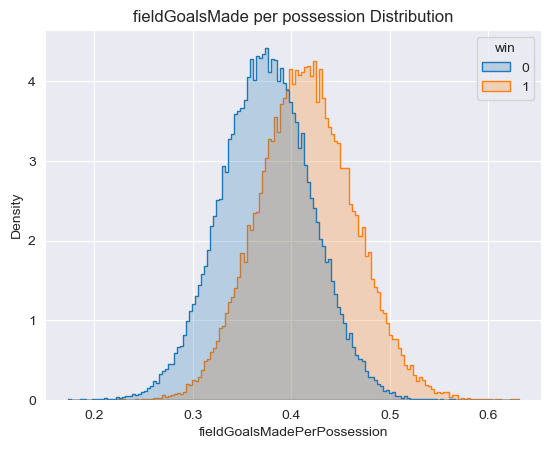

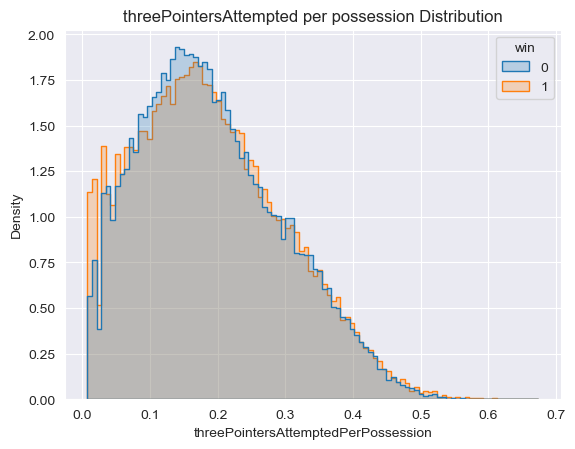

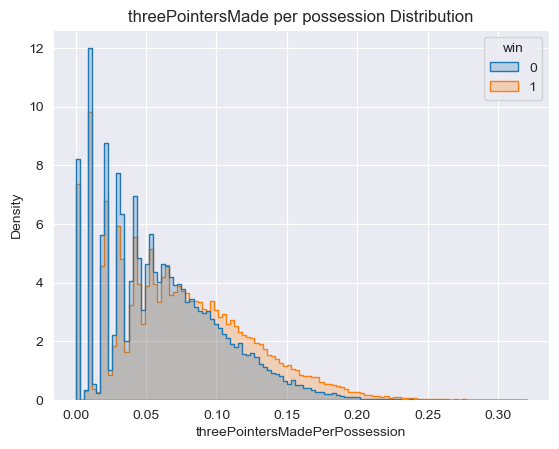

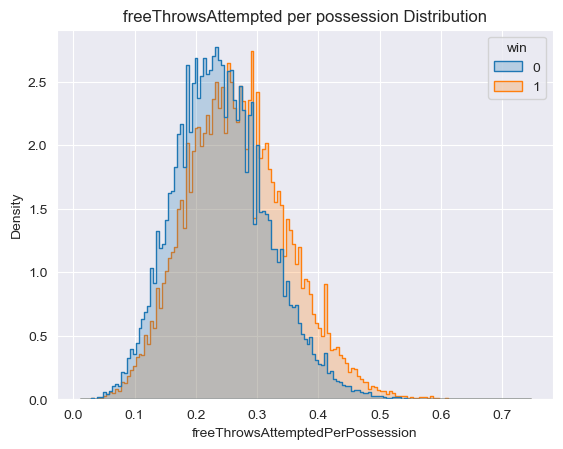

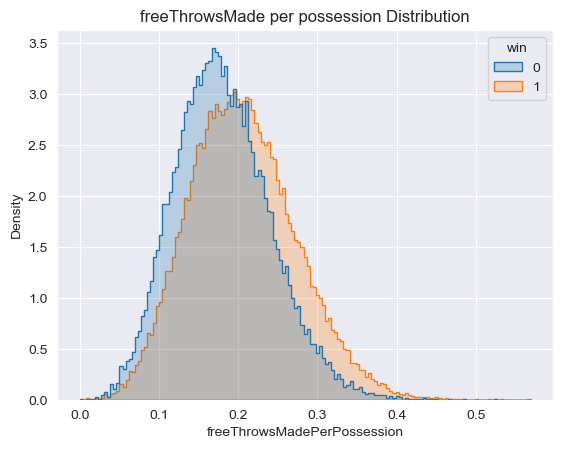

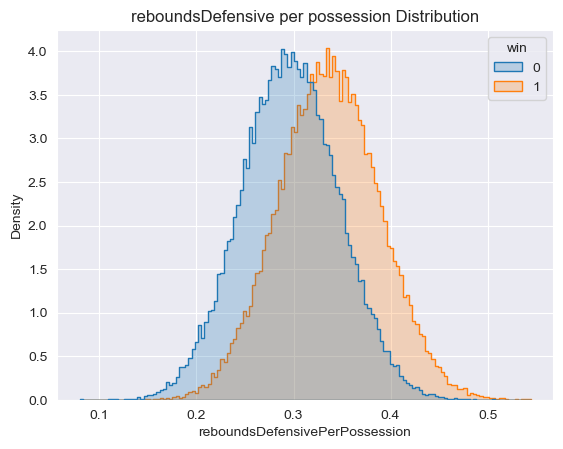

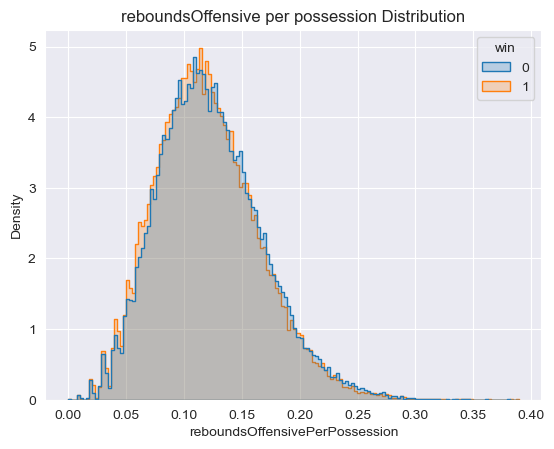

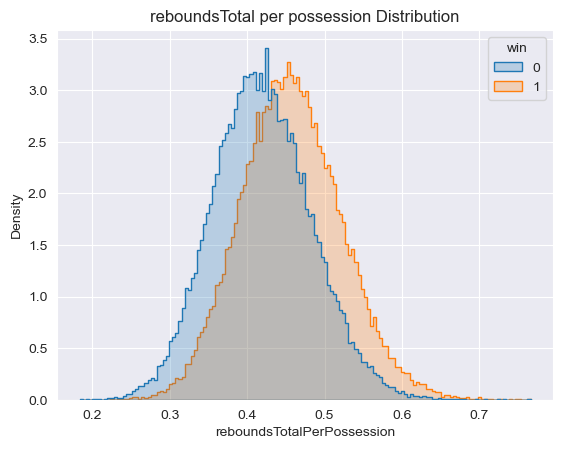

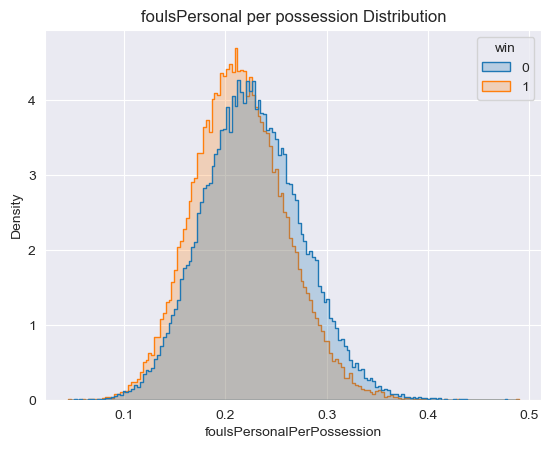

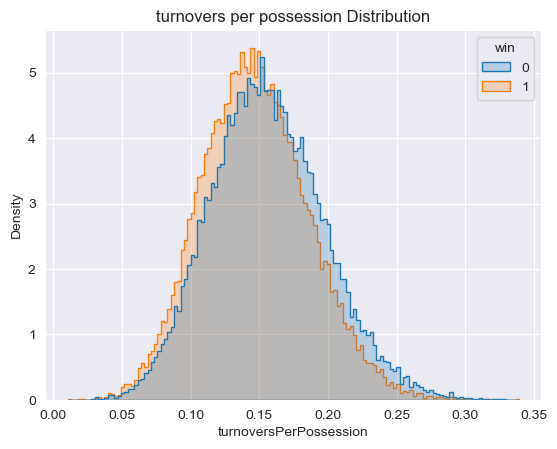

In [107]:
per_possession_cols = ["teamScore", "assists", "blocks", "steals",
                 "fieldGoalsAttempted", "fieldGoalsMade",
                 "threePointersAttempted", "threePointersMade",
                 "freeThrowsAttempted", "freeThrowsMade",
                 "reboundsDefensive", "reboundsOffensive",
                 "reboundsTotal", "foulsPersonal", "turnovers"]

for col in per_possession_cols:
    team_statistics_df[col + "PerPossession"] = team_statistics_df[col] / team_statistics_df["possessions"]
    sns.histplot(data=team_statistics_df, x=col + "PerPossession", hue='win', element='step', stat='density')
    plt.title(f"{col} per possession Distribution")
    plt.show()

In [108]:
# Save the dataframe to a csv file
team_statistics_df.to_csv(os.path.join(DATA_PATH, "team_statistics_per_possession.csv"), index=False)

We can now move on to testing:

In [109]:
win = team_statistics_df[team_statistics_df["win"] == 1]
loss = team_statistics_df[team_statistics_df["win"] == 0]
paired = pd.merge(win, loss, on=["gameId"], suffixes=("_win", "_loss"))

In [111]:
cols = [c for c in team_statistics_df.columns if c.endswith("PerPossession") or c.endswith("Percentage")]
differences = paired[[f"{col}_win" for col in cols]].values - paired[[f"{col}_loss" for col in cols]].values
differences = pd.DataFrame(differences, columns=cols)

['fieldGoalsPercentage', 'threePointersPercentage', 'freeThrowsPercentage', 'teamScorePerPossession', 'assistsPerPossession', 'blocksPerPossession', 'stealsPerPossession', 'fieldGoalsAttemptedPerPossession', 'fieldGoalsMadePerPossession', 'threePointersAttemptedPerPossession', 'threePointersMadePerPossession', 'freeThrowsAttemptedPerPossession', 'freeThrowsMadePerPossession', 'reboundsDefensivePerPossession', 'reboundsOffensivePerPossession', 'reboundsTotalPerPossession', 'foulsPersonalPerPossession', 'turnoversPerPossession']


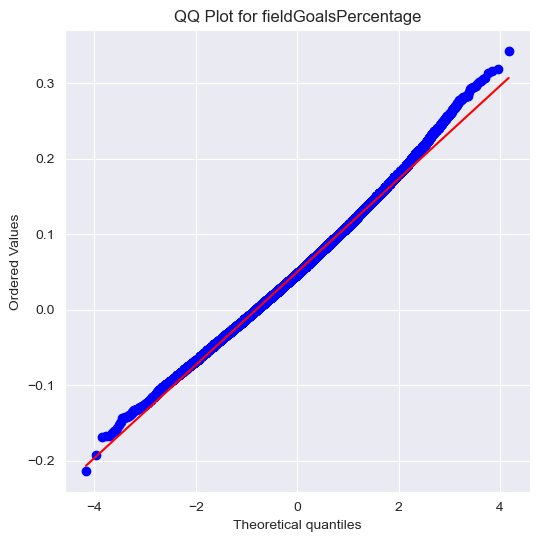

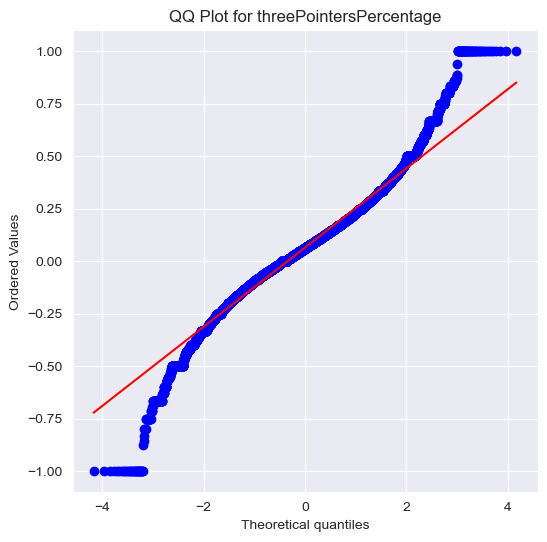

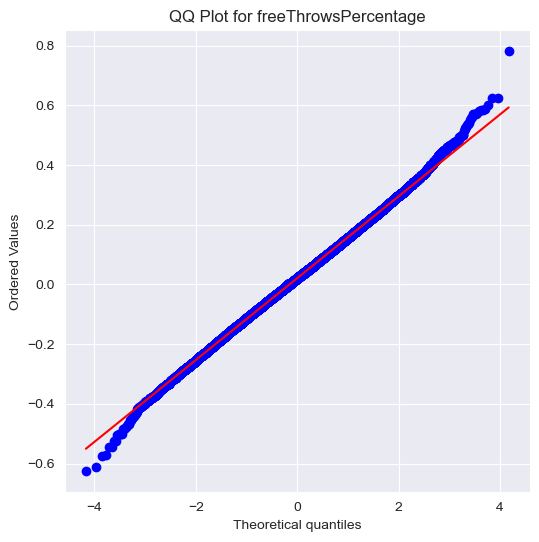

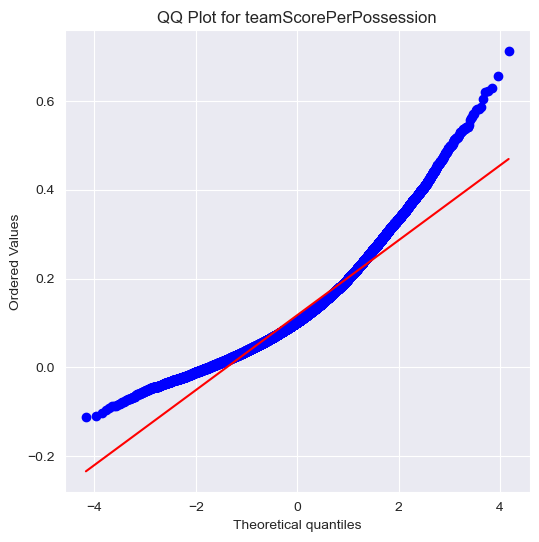

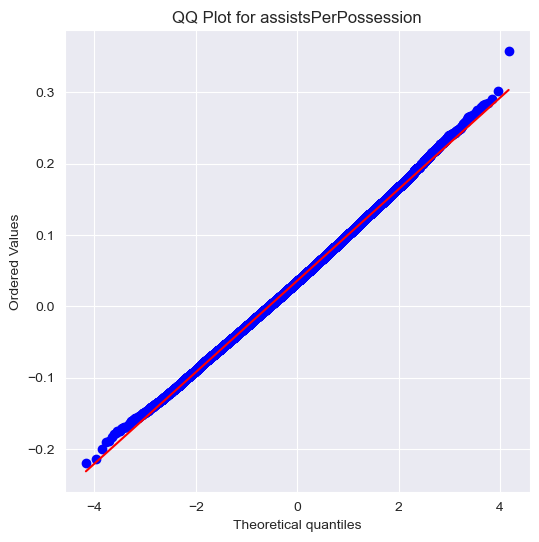

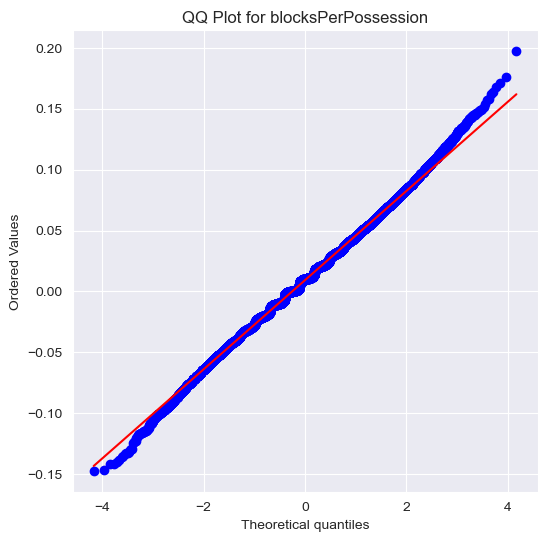

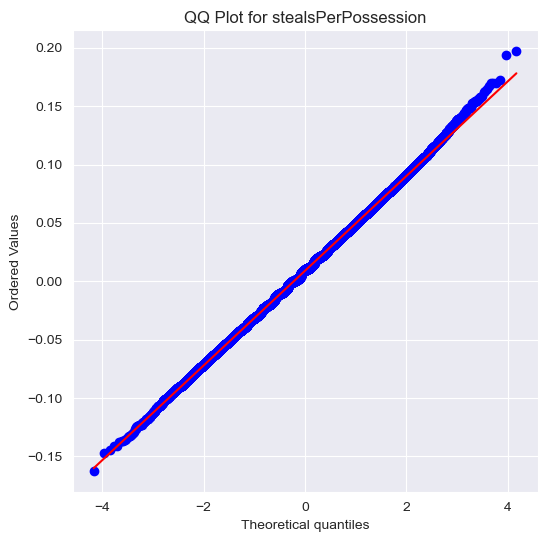

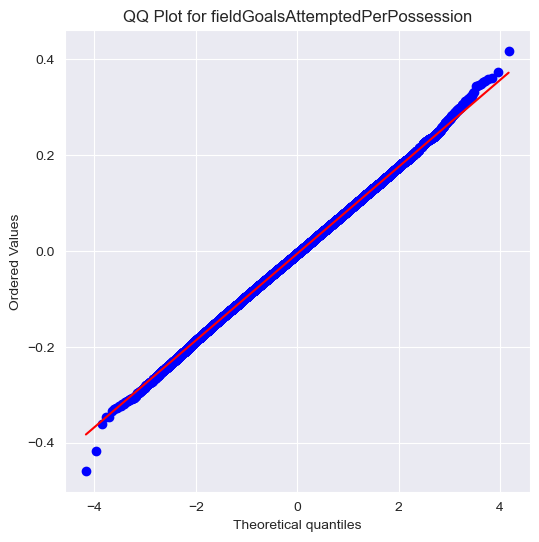

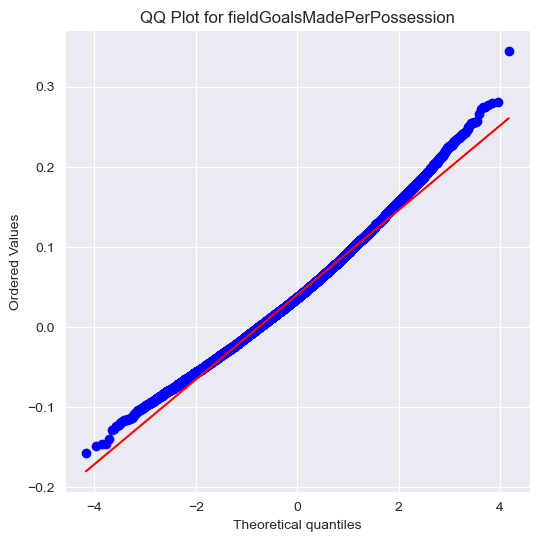

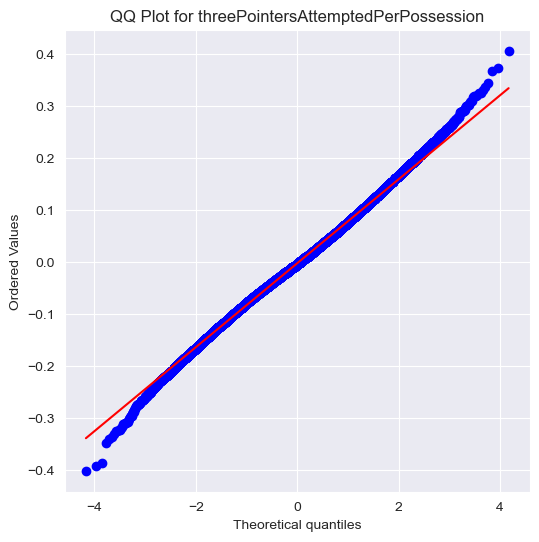

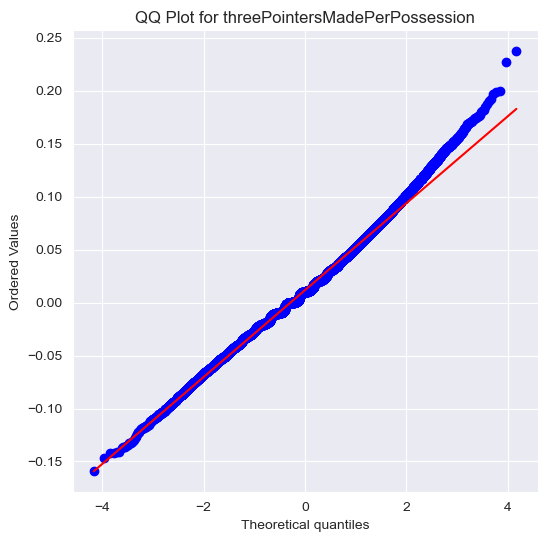

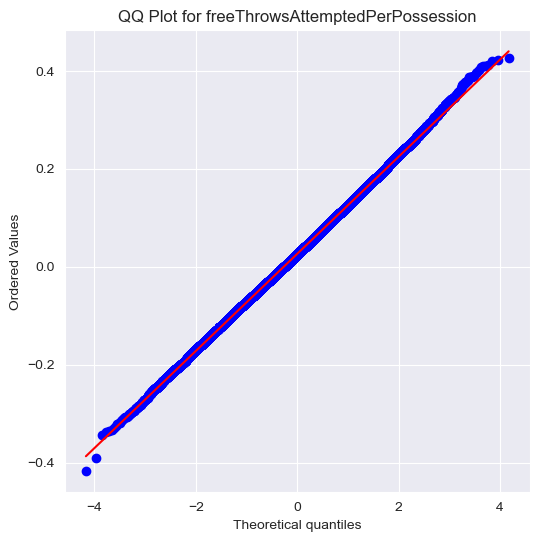

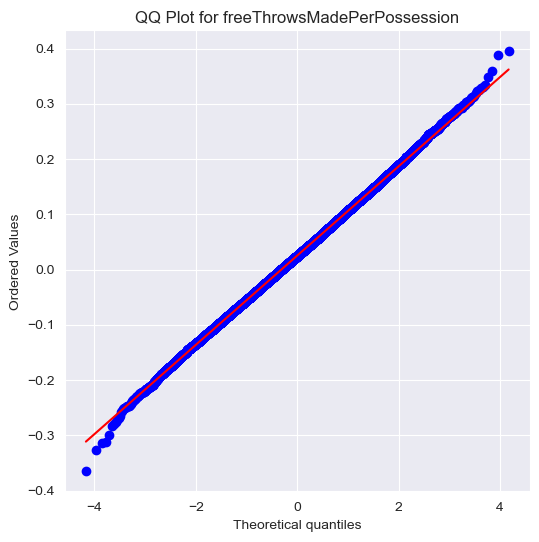

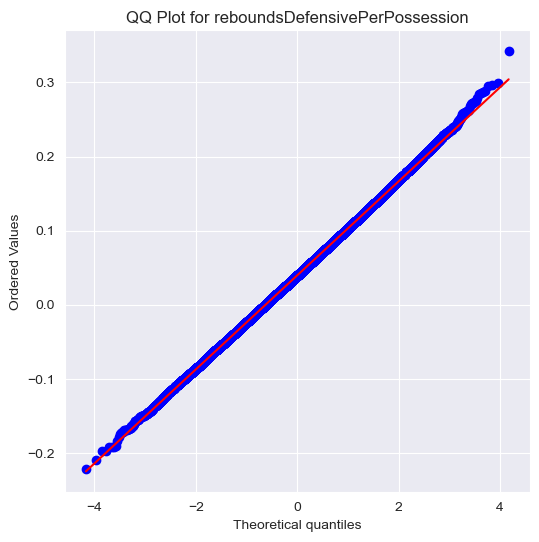

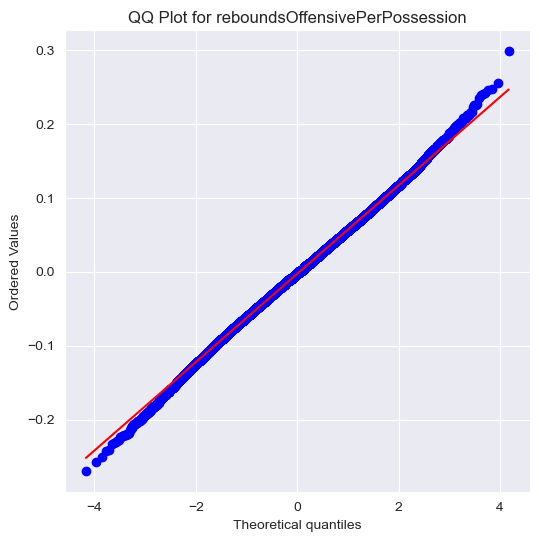

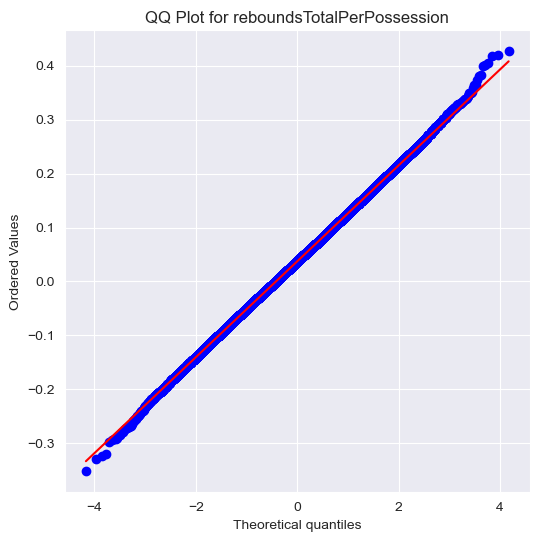

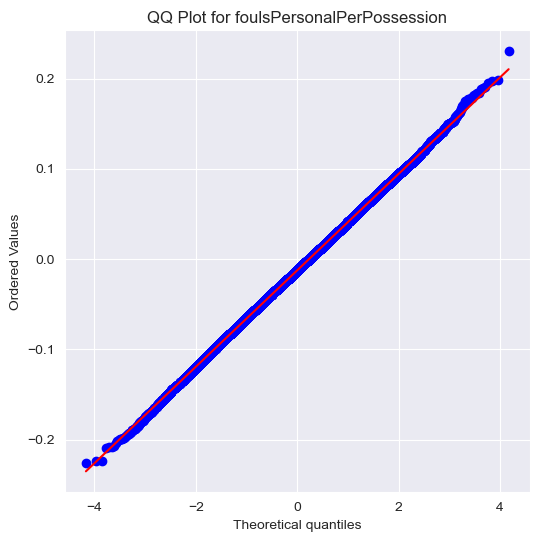

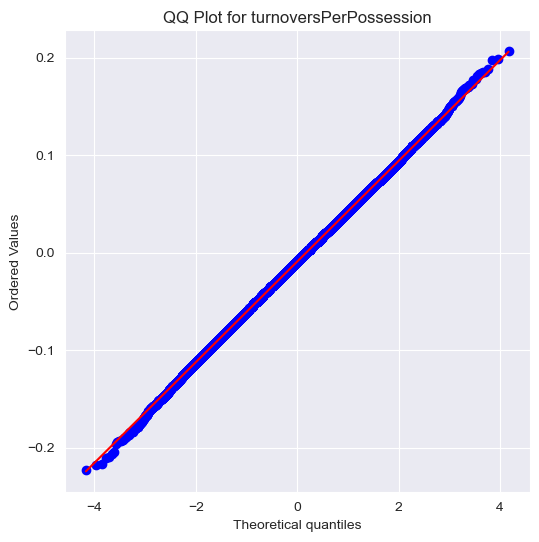

In [114]:
# Plot QQ Plots
for col in differences.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()